# Data exploration (Second Data)

In [75]:
import pandas as pd
import itertools
from wordcloud import WordCloud

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import cohen_kappa_score
from math import isnan

nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/ahmet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ahmet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
data = pd.read_csv('/Users/ahmet/Desktop/Study/second_semester/nlp/project/data/clean_data2.csv')
data2 = pd.read_excel('data/Gourley_p6.xlsx', sheet_name='Original Data')

In [22]:
# find NaN messages
nan_idx = data2[data2['Message'].isna()].index

# drop NaN messages
data2 = data2.drop(nan_idx)

In [23]:
uptake = []
dis_type = []

for column in data2.columns:
    if 'Uptake' in column:
        uptake.append(column)
    elif 'Discussion Type' in column:
        dis_type.append(column)
    else:
        pass

In [24]:
for u, d in zip(uptake, dis_type):
    data2[u] = data2[u].astype('str')
    data2[d] = data2[d].astype('str')

In [79]:
uptake_kappa = []
uptake_comb = list(itertools.product(uptake, uptake))
for tup in uptake_comb:
    score = cohen_kappa_score(data2[tup[0]], data2[tup[1]])
    uptake_kappa.append(score)
    
uptake_scores = {}
for n, s in zip(uptake_comb, uptake_kappa):
    uptake_scores[str(n)] = s
    
uptake_scores = {k: v for k, v in uptake_scores.items() if (v != 1.0) & (not isnan(v))}
uptake_scores

{"('MG Uptake', 'SS Uptake')": 0.2277695199790155,
 "('MG Uptake', 'ZH Uptake')": 0.274590697876406,
 "('MG Uptake', 'NT Uptake')": 0.0,
 "('SS Uptake', 'MG Uptake')": 0.2277695199790155,
 "('SS Uptake', 'ZH Uptake')": 0.29558993442672155,
 "('SS Uptake', 'NT Uptake')": 0.0,
 "('ZH Uptake', 'MG Uptake')": 0.2745906978764058,
 "('ZH Uptake', 'SS Uptake')": 0.29558993442672143,
 "('ZH Uptake', 'NT Uptake')": 0.0,
 "('NT Uptake', 'MG Uptake')": 0.0,
 "('NT Uptake', 'SS Uptake')": 0.0,
 "('NT Uptake', 'ZH Uptake')": 0.0}

In [78]:
dis_kappa = []
dis_comb = list(itertools.product(dis_type, dis_type))

for tup in dis_comb:
    score = cohen_kappa_score(data2[tup[0]], data2[tup[1]])
    dis_kappa.append(score)
    
dis_scores = {}
for n, s in zip(dis_comb, dis_kappa):
    dis_scores[n] = s
    
dis_scores = {k: v for k, v in dis_scores.items() if (v != 1.0) & (not isnan(v))}
dis_scores

{('SS Discussion Type', 'MG Discussion Type'): 0.5568211967384191,
 ('SS Discussion Type', 'ZH Discussion Type'): 0.5459366489895371,
 ('SS Discussion Type', 'NT Discussion Type+$J$514:$J$520'): 0.0,
 ('MG Discussion Type', 'SS Discussion Type'): 0.5568211967384191,
 ('MG Discussion Type', 'ZH Discussion Type'): 0.4302983680422001,
 ('MG Discussion Type', 'NT Discussion Type+$J$514:$J$520'): 0.0,
 ('ZH Discussion Type', 'SS Discussion Type'): 0.5459366489895371,
 ('ZH Discussion Type', 'MG Discussion Type'): 0.4302983680422001,
 ('ZH Discussion Type', 'NT Discussion Type+$J$514:$J$520'): 0.0,
 ('NT Discussion Type+$J$514:$J$520', 'SS Discussion Type'): 0.0,
 ('NT Discussion Type+$J$514:$J$520', 'MG Discussion Type'): 0.0,
 ('NT Discussion Type+$J$514:$J$520', 'ZH Discussion Type'): 0.0}

NT Uptake is full of NaN's so that's why it's kappa score is 0 when we compare it with other annotators and NaN with itself.

In [47]:
data2['NT Uptake'].value_counts()

NT Uptake
nan    288
Name: count, dtype: int64

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   book_id          290 non-null    object 
 1   topic            289 non-null    object 
 2   bookclub         290 non-null    object 
 3   message          288 non-null    object 
 4   time             287 non-null    object 
 5   is_answer        287 non-null    object 
 6   page             287 non-null    float64
 7   question         0 non-null      float64
 8   pivot            0 non-null      float64
 9   dialogic_spell   178 non-null    float64
 10  discussion_type  290 non-null    object 
 11  uptake           281 non-null    object 
 12  pseudonym        288 non-null    object 
dtypes: float64(4), object(9)
memory usage: 29.8+ KB


In [70]:
columns_to_analyze = ['book_id', 'topic', 'bookclub',
                      'message', 'time', 'is_answer',
                      'page', 'uptake', 'discussion_type']

In [71]:
# find NaN messages
nan_idx = data[data['message'].isna()].index

# drop NaN messages
data = data.drop(nan_idx)
data = data[columns_to_analyze]

In [72]:
# conver time to datetime object
data.time = pd.to_datetime(data.time)

In [75]:
def add_time_features(data):
    
    data['minute'] = data.time.dt.minute
    data['hour'] = data.time.dt.hour
    data['day'] = data.time.dt.day
    data['month'] = data.time.dt.month
    data['year'] = data.time.dt.year
    
    return data

In [76]:
data = add_time_features(data)
data.head()

,book_id,topic,bookclub,message,time,is_answer,page,uptake,discussion_type,minute,hour,day,month,year
0,306,"Using the chat discussion to the right, discus...",Book Club One,hello,2022-03-01 14:41:05,No,8.0,Filler,Social,41.0,14.0,1.0,3.0,2022.0
1,306,"Using the chat discussion to the right, discus...",Book Club One,yoooo wasssupppp,2022-03-01 14:41:21,No,8.0,Filler,Social,41.0,14.0,1.0,3.0,2022.0
2,306,"Using the chat discussion to the right, discus...",Book Club One,hola,2022-03-01 14:41:42,No,6.0,Filler,Social,41.0,14.0,1.0,3.0,2022.0
3,306,"Using the chat discussion to the right, discus...",Book Club One,yoooo wasssupppp yooo,2022-03-01 14:42:04,No,8.0,Filler,Social,42.0,14.0,1.0,3.0,2022.0
4,306,"Using the chat discussion to the right, discus...",Book Club One,so lets start out,2022-03-01 14:42:54,No,8.0,Prompt,Deliberation,42.0,14.0,1.0,3.0,2022.0


In [77]:
print('Minute')
display(data.minute.value_counts().sort_index())
print('Hour')
display(data.hour.value_counts().sort_index())
print('Day')
display(data.day.value_counts().sort_index())
print('Month')
display(data.month.value_counts().sort_index())
print('Year')
display(data.year.value_counts().sort_index())

Minute


minute
0.0      5
1.0     12
2.0     12
3.0     14
4.0      9
5.0      6
6.0      5
7.0      9
8.0      6
9.0     14
10.0     4
11.0     7
12.0     3
13.0    10
14.0     6
15.0    10
16.0     8
17.0     3
18.0     3
19.0     2
20.0     6
21.0     5
22.0     2
23.0     3
40.0     2
41.0     9
42.0     7
43.0     7
44.0     2
45.0     3
46.0     6
47.0     7
48.0     4
49.0     4
50.0     2
51.0     8
52.0     4
53.0     6
54.0     5
55.0     9
56.0    11
57.0    10
58.0     9
59.0     8
Name: count, dtype: int64

Hour


hour
14.0    123
15.0    164
Name: count, dtype: int64

Day


day
1.0    287
Name: count, dtype: int64

Month


month
3.0    287
Name: count, dtype: int64

Year


year
2022.0    287
Name: count, dtype: int64

### Wordcloud

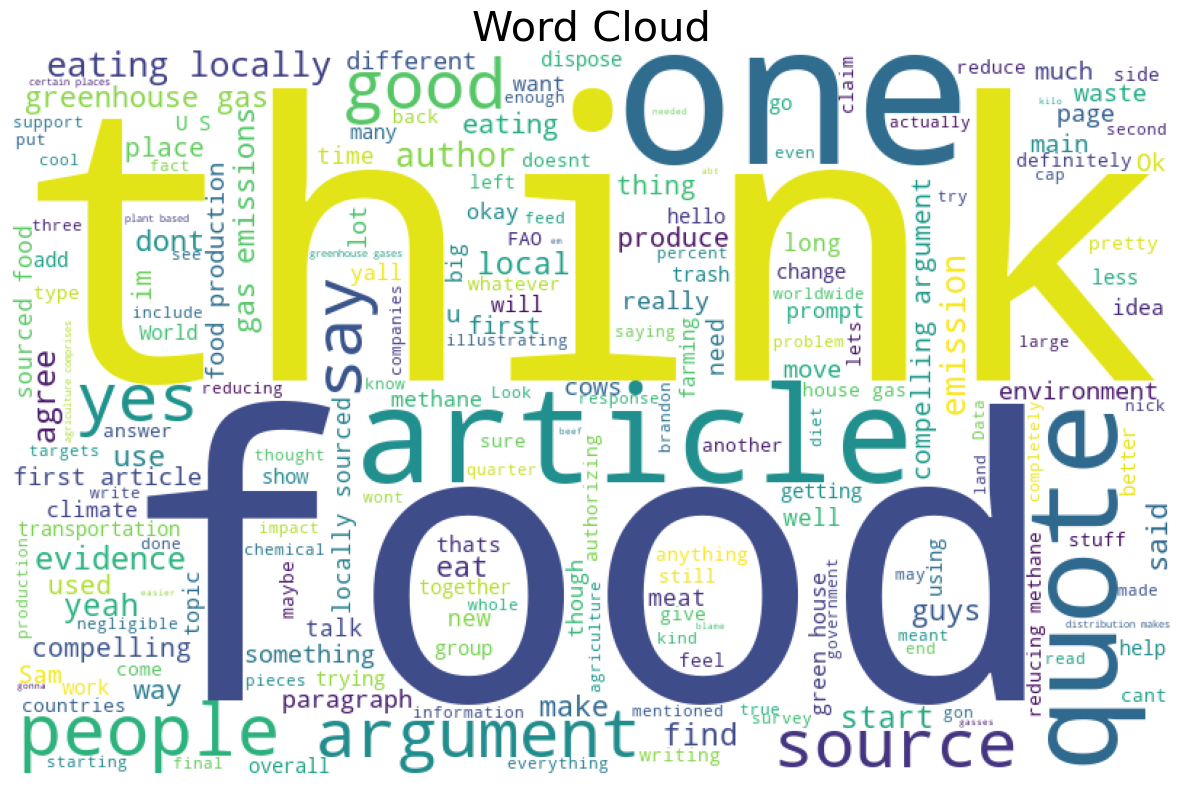

In [106]:
messages = data['message']

plt.figure(figsize=(15, 15))
wc = WordCloud(background_color='white',
               width=800,
               height=500).generate(" ".join(messages))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud', fontsize=30)
plt.show()

### Messages over minutes

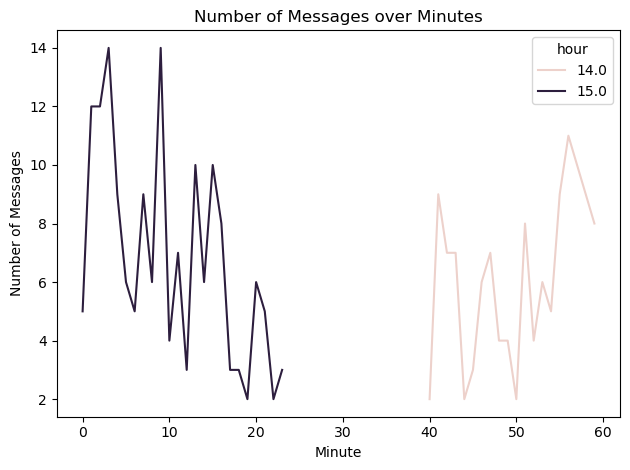

In [107]:
min_data = data.groupby(['hour','minute']).size().reset_index()
min_data = min_data.rename(columns = {0: 'count'})

sns.lineplot(min_data, x = 'minute', y = 'count', hue = 'hour')
plt.xlabel('Minute')
plt.ylabel('Number of Messages')
plt.title('Number of Messages over Minutes')
plt.tight_layout()
plt.show()

### Message length distribution

In [108]:
message_lengths = data['message'].str.len()

fig = px.histogram(x=message_lengths, nbins=50, labels={'x': 'Message Length', 'y': 'Frequency'})
fig.update_layout(title='Distribution of Message Lengths')
fig.show()

### TF-IDF - Most important words

In [112]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    return stemmed_tokens

In [134]:
# Example documents
sentences = data.message.values

# Preprocess documents
preprocessed_sentences = [' '.join(preprocess_text(sent)) for sent in sentences]
joined_sentences = ' '.join(preprocessed_sentences)

# Compute TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform([joined_sentences])


In [147]:
feature_names = vectorizer.get_feature_names_out()

In [168]:
tfidf_scores = tfidf_matrix[0, :]

# Create a dictionary mapping words to their TF-IDF scores
word_to_tfidf = {feature_names[i]: tfidf_scores[0, i] for i in range(len(feature_names))}

# Sort based on value
print('Top 20 words according to tfidf:')
top_20 = sorted(word_to_tfidf, key = word_to_tfidf.get, reverse = True)[:20]
print(top_20)

Top 20 words according to tfidf:
['food', 'local', 'eat', 'think', 'articl', 'one', 'use', 'argument', 'emiss', 'like', 'sourc', 'compel', 'author', 'say', 'peopl', 'quot', 'first', 'ga', 'get', 'make']


In [169]:
# Count the number of messages per book club
message_counts_by_bookclub = data['bookclub'].value_counts()

# Create a bar chart using Plotly Express
fig = px.bar(x=message_counts_by_bookclub.index, y=message_counts_by_bookclub.values, 
             labels={'x': 'Book Club', 'y': 'Number of Messages'},
             title='Distribution of Messages by Book Club')
fig.show()

In [172]:
# Define the columns for which you want to create plots
columns_to_plot = ['uptake', 'discussion_type']

# Create plots for each category
for column in columns_to_plot:
    # Replace NaN values with 'None' for categorical columns
    data[column] = data[column].fillna('None')
    
    # Count the number of messages per category
    message_counts_by_category = data[column].value_counts()
    
    # Create a bar chart using Plotly Express
    fig = px.bar(x=message_counts_by_category.index, y=message_counts_by_category.values, 
                 labels={'x': column, 'y': 'Number of Messages'},
                 title=f'Distribution of Messages by {column}')
    fig.show()